Contributors: 
Peter Harmer,
Girish Dodda

In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\giris\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, RandomSampler
import re

In [3]:
#Initializing
gpu_available = torch.cuda.is_available()
if gpu_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("GPU available: {}".format(gpu_available))

GPU available: False


In [4]:
#Load & check Data

colab = False

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    data = pd.read_csv('drive/My Drive/COMP SCI 539/bbc-news-data.csv', delimiter='\t')
else:
    data = pd.read_csv('bbc-news-data.csv', delimiter='\t')

data.head()

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...


category    0
filename    0
title       0
content     0
dtype: int64


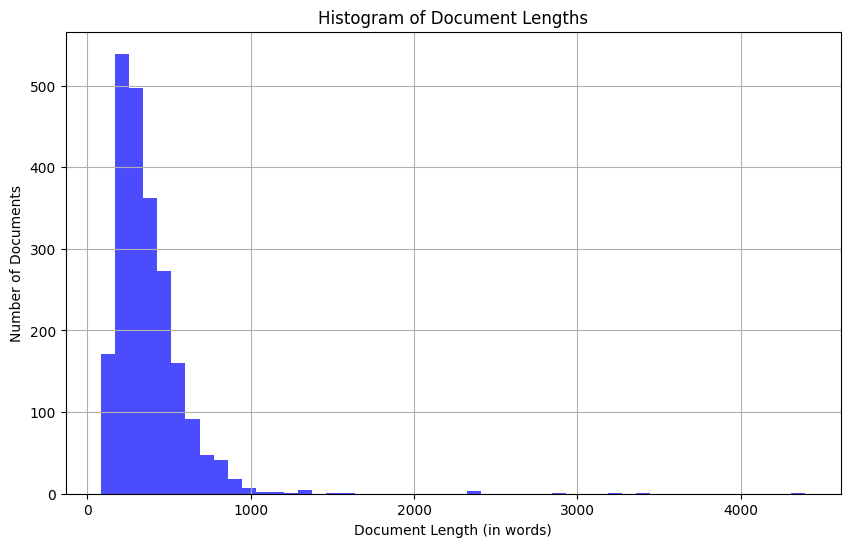

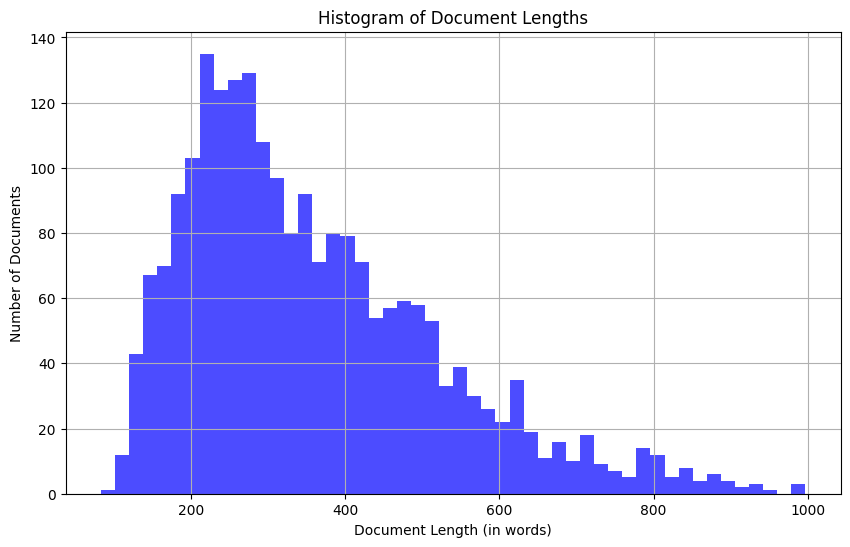

In [5]:
#Data Preprocessing

# Find and remove nulls
print(data.isnull().sum())

# Data to lowercase
data["title"] = data["title"].str.lower()
data["content"] = data["content"].str.lower()
# Remove and replace contractions
#Find more contraction in text and add
contraction_dict = {"can't":"cannot","didn't":"did not","aren't":"are not","she'd":"she would","he'd":"he would","they'd":"they would","they've":"they have",
"shouldn't":"should not","shouldn't've":"should not have","she'll":"she will","he'll":"he will","they'll":"they will"
}

def contraction_replacer(text):
    for word in text.split():
        if word in contraction_dict:
            text = text.replace(word, contraction_dict[word])
    return text

data["title"] = data["title"].apply(contraction_replacer)
data["content"] = data["content"].apply(contraction_replacer)

# Remove punctuation and numbers
#Find more punctuation in text and add

punctuation_numbers = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~0123456789'

def punctuation_numbers_remover(text):
    for punctuation in punctuation_numbers:
        text = text.replace(punctuation, '')
    return text

data["title"] = data["title"].apply(punctuation_numbers_remover)
data["content"] = data["content"].apply(punctuation_numbers_remover)

data.head()

# plot the distribution of the lengths of the sequences
content_lengths = [len(content.split()) for content in data["content"]]


plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(content_lengths, bins=50, color='blue',
         alpha=0.7)  # Adjust bins as needed
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length (in words)')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

# remove the outliers
MAX_CONTENT_LENGTH = 1000
MAX_TITLE_LENGTH = 10
# get the indices of the documents that have more than 1000 words
outliers = [idx for idx, length in enumerate(
    content_lengths) if length > MAX_CONTENT_LENGTH]

# remove the outliers from the data
data = data.drop(outliers, axis=0).reset_index(drop=True)

# plot the distribution of the lengths of the sequences
content_lengths = [len(content.split()) for content in data["content"]]
plt.figure(figsize=(10, 6))  # Set the size of the plot
plt.hist(content_lengths, bins=50, color='blue',
         alpha=0.7)  # Adjust bins as needed
plt.title('Histogram of Document Lengths')
plt.xlabel('Document Length (in words)')
plt.ylabel('Number of Documents')
plt.grid(True)
plt.show()

In [30]:
class Vocab:
    def __init__(self):
        self.word2index = {"PAD": 0, "UNK": 3}
        self.index2word = {0: "PAD", 3: "UNK"}
        self.word2count = {}
        self.n_words = 2 

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def tokenize(self, sentence, seq_len=None):
        # Add Start Of Sentence token
        token_seq_idx = []

        # Tokenize each word in sentence
        for tkn in sentence.split():
            token_seq_idx.append(
                self.word2index[tkn if tkn in self.word2index else "UNK"])


        if seq_len is not None:
            if len(token_seq_idx) < seq_len:
                # Pad to desired length
                token_seq_idx += [self.word2index["PAD"]] * \
                    (seq_len - len(token_seq_idx))
            else:
                # Trim sentence to length
                token_seq_idx = token_seq_idx[:seq_len]

        return token_seq_idx

    def list2sentence(self, seq_ids):
        return " ".join([self.index2word[idx] for idx in seq_ids])


print("Creating vocab...")
vocab = Vocab()
for content in data["content"]:
    vocab.addSentence(content)

# Test it out
print("Number of words in vocab: {}".format(vocab.n_words))
# pick a random sequence from the data
random_idx = np.random.randint(0, len(data))
print("Original text: {}".format(data["content"][random_idx]))
# tokenize the text
tokenized_text = vocab.tokenize(data["content"][random_idx])
print("Tokenized text: {}".format(tokenized_text))
# convert back to text
converted_text = vocab.list2sentence(tokenized_text)
print("Converted text: {}".format(converted_text))

Creating vocab...
Number of words in vocab: 31568
Original text:  wales coach mike ruddock has made two changes from the team that beat italy  for saturday's trip to france  kevin morgan takes over from his injured newportgwent dragons colleague hal luscombe on the right wing and in the pack neathswansea ospreys forward ryan jones is preferred at blindside flanker to jonathan thomas thomas a tryscorer in rome drops down to the bench instead of ian gough while cardiff back rhys williams steps up in place of morgan luscombe is sidelined by a hamstring problem sustained during the six nations game against italy last weekend  however the experienced and inform morgan was already pushing hard for a start at stade de france due to his impressive performances from the bench kevin was very much in the selection mix anyway and the unfortunate injury to hal gives him the chance to start said ruddock now that ryan jones has recovered from injury we have increased the options in the back row jonat

In [31]:
def create_dataloaders(batch_size):
    n = len(data)
    print("Creating dataloaders with {} samples...".format(n))
    content_seqs_ids = torch.zeros((n, MAX_CONTENT_LENGTH)).long()
    title_seqs_ids = torch.zeros((n, MAX_TITLE_LENGTH)).long()

    for idx, content in enumerate(data["content"]):
        # Tokenize and add to tensor
        content_seqs_ids[idx] = torch.tensor(
            vocab.tokenize(content, seq_len=MAX_CONTENT_LENGTH))
        
    for idx, title in enumerate(data["title"]):
        title_seqs_ids[idx] = torch.tensor(
            vocab.tokenize(title, seq_len=MAX_TITLE_LENGTH))

    # Split into training and testing
    train_sample_mask = torch.rand((n,)) > 0.3

    train_content_seqs_ids = content_seqs_ids[train_sample_mask]
    train_title_seqs_ids = title_seqs_ids[train_sample_mask]
    test_content_seqs_ids = content_seqs_ids[~train_sample_mask]
    test_title_seqs_ids = title_seqs_ids[~train_sample_mask]
    

    # Create train dataloader
    train_data = TensorDataset(train_content_seqs_ids.to(
        device), train_title_seqs_ids.to(device))
    train_dataloader = DataLoader(
        train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    # Create test dataloader
    test_data = TensorDataset(test_content_seqs_ids.to(
        device), test_title_seqs_ids.to(device))
    test_dataloader = DataLoader(test_data, sampler=RandomSampler(train_data), batch_size=batch_size)

    return train_dataloader, test_dataloader


# Test the dataloader
train_dataloader, test_dataloader = create_dataloaders(32)
for cont, titl in train_dataloader:
    print('Batch | cont =', cont.shape, '| titl =', titl.shape)
    print('First content: ', vocab.list2sentence(cont[0].tolist()))
    print('First title:', vocab.list2sentence(titl[0].tolist()))
    break

Creating dataloaders with 2204 samples...
Batch | cont = torch.Size([32, 1000]) | titl = torch.Size([32, 10])
First content:  a prescription cannabis drug made by uk biotech firm gw pharmaceuticals is set to be approved in canada the drug is used to treat the central nervous system and alleviate the symptoms of multiple sclerosis ms a few weeks ago shares in gw pharma lost a third of their value after uk regulators said they wanted more evidence about the drug's benefits but now canadian authorities have said the sativex drug will be considered for approval approximately people in canada have been diagnosed with ms and people are suffering from the condition in the uk many patients already smoke cannabis to relieve their symptoms now gw pharma's sativex mouth spray could be legally available to ms sufferers in canada within the next few months this will be the first time a cannabisbased drug has been approved anywhere in the world representing a landmark for gw pharma and for patients 

In [44]:
sentence = 'the cat sat on the hat with a brown bat'
seq = torch.tensor([vocab.word2index[w]
                      for w in sentence.split()]).unsqueeze(0)
print(seq.shape)

torch.Size([1, 10])


In [45]:
class RNNEncoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, dropout_rate=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.rnn = nn.LSTM(input_size=d_model, hidden_size=d_model,
                           num_layers=num_layers, dropout=dropout_rate, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        # Shape `(batch_size, seq_len, d_model)`.
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.rnn(embedded)
        return outputs  # Shape `(batch_size, seq_len, d_model)`.
    

# Example usage
rnn_encoder = RNNEncoder(vocab_size=vocab.n_words,
                         d_model=512, num_layers=3, dropout_rate=0.1).to(device)
print('Batch of Contents:', seq.shape)
print('Output of RNN Encoder:', rnn_encoder(seq.to(device)).shape)

Batch of Contents: torch.Size([1, 10])
Output of RNN Encoder: torch.Size([1, 10, 512])


In [52]:
class ExtractiveSummarizer(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, dropout_rate=0.1, threshold=0.5, sum_len = 10, pad_token = 0):
        super().__init__()
        self.encoder = RNNEncoder(
            vocab_size, d_model, num_layers, dropout_rate)
        self.scoring_layer = nn.Linear(d_model, 1)
        self.threshold = nn.Parameter(torch.tensor(threshold))
        self.sum_len = sum_len
        self.pad_token = pad_token

    def forward(self, x):
        # Encoder outputs
        # Shape `(batch_size, seq_len, d_model)`.
        encoder_outputs = self.encoder(x)

        # Scoring each word
        # Shape `(batch_size, seq_len)`.
        scores = self.scoring_layer(encoder_outputs).squeeze(-1)
        selected = scores > self.threshold

        return scores, selected


summarizer = ExtractiveSummarizer(vocab_size=vocab.n_words, d_model=512, num_layers=3, dropout_rate=0.1, threshold=0.6, sum_len=MAX_TITLE_LENGTH, pad_token=vocab.word2index["PAD"]).to(device)

# Get the scores and selected words
scores, selected = summarizer(seq)

# Print the results
print("Scores:\n", scores)
print("Selected (Binary Mask):\n", selected)

Scores:
 tensor([[0.0332, 0.0309, 0.0279, 0.0280, 0.0278, 0.0298, 0.0297, 0.0289, 0.0279,
         0.0275]], grad_fn=<SqueezeBackward1>)
Selected (Binary Mask):
 tensor([[False, False, False, False, False, False, False, False, False, False]])


In [60]:
def selectedToSummary(selected, scores, x, sum_len, pad_token):
    top_scores, top_indices = torch.topk(
        scores, k=sum_len, dim=-1, sorted=False)
    # Initialize an empty tensor for the summary indices

    summary_tokens = torch.full((x.size(
        0), sum_len), fill_value=pad_token, dtype=torch.long, device=x.device)
    # Fill in the indices of the top scoring words

    for i in range(x.size(0)):  # Loop over batch
        # Number of selected words or sum_len
        length = min(sum_len, (selected[i]).sum().item())
        summary_tokens[i, :length] = top_indices[i, :length]

    return summary_tokens

# Test the functions
summary_tokens = selectedToSummary(selected, scores, seq, MAX_TITLE_LENGTH, vocab.word2index["PAD"])
print("Summary Tokens:\n", summary_tokens)
print("Summary:\n", vocab.list2sentence(summary_tokens[0].tolist()))

Summary Tokens:
 tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Summary:
 PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD


In [50]:
#Hyperparameters
dropout = 0.1
hidden_dim = 512
num_layers = 3
threshold = 0.5
lr= 0.01
n_epochs = 20
summation_length = MAX_TITLE_LENGTH

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def fit(model, dataloader, optimizer, criterion, epochs, device):
    model.train()
    loss_history = []

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            inputs, targets = batch
            print(targets.shape)
            inputs, targets = inputs.to(device), targets.to(device)


            optimizer.zero_grad()

            # Forward pass
            scores, summary_tokens = model(inputs)

            # Reshape or align outputs and targets if necessary
            # Example: outputs might need to be reshaped or targets might need to be converted
            # This depends on the specific output format of your model and the criterion requirements
            # loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))

            print(targets.shape, outputs.shape)


            loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        loss_history.append(avg_loss)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

    return loss_history

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch in dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            # Same as in fit function, adjust loss calculation based on output and target format
            # loss = criterion(outputs.view(-1, outputs.size(-1)), targets.view(-1))


            loss = criterion(outputs, targets)
            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


# Example usage
# Assuming you have a dataloader for training and validation
batch_size = 32
train_dataloader, test_dataloader = create_dataloaders(batch_size)

model = ExtractiveSummarizer(vocab_size=vocab.n_words, d_model=hidden_dim, num_layers=num_layers, dropout_rate=dropout, threshold=threshold).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

epochs = 10
train_loss_history = fit(model, train_dataloader, optimizer, criterion, epochs, device)
val_loss = evaluate(model, test_dataloader, criterion)

# Plotting
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

Creating dataloaders with 2204 samples...
[tensor([[    6, 12549,  3949,  ...,     0,     0,     0],
        [ 1591,    70,  1627,  ...,     0,     0,     0],
        [12162, 16214, 16215,  ...,     0,     0,     0],
        ...,
        [ 2587,  4968,    24,  ...,     0,     0,     0],
        [ 1982,     5,  5955,  ...,     0,     0,     0],
        [  475,    24,    11,  ...,     0,     0,     0]]), tensor([[ 1340,   182,   215, 15831, 14158,     0,     0,     0,     0,     0],
        [ 1591,     3,   411,   808,  2217,     0,     0,     0,     0,     0],
        [16216, 12162, 16215,     3,     0,     0,     0,     0,     0,     0],
        [27010,  1917,   927, 18884,  2512,     0,     0,     0,     0,     0],
        [13232, 14132,   652, 13343, 12624,     0,     0,     0,     0,     0],
        [23848,  9527,    14, 10286,   338,     0,     0,     0,     0,     0],
        [ 2833,   869,   239,   639,    14, 15542,     0,     0,     0,     0],
        [12980,  3768,   808,  730

KeyboardInterrupt: 